# Investigating The Efficacy of Data Profiles in the Prediction of Pulsar Star Class.

## Introduction

A pulsar star is a neutron star with a high mass that emits electromagnetic radiation when it collapses. This emission of radiation can be detected as radio waves by telescopes thus giving them a unique integrated pulse profile and DM-SNR curve. These profiles can be used to classify a signal as either pulsar or non-pulsar.

### Main Question

Does the integrated pulse profile or the DM-SNR curve better predict whether an emission signal is from a pulsar star? 

### The Dataset

This dataset (https://archive.ics.uci.edu/ml/datasets/HTRU2) represents a collection of observed radio emissions that have been confirmed to be either from pulsar stars (Class 1), or a mix of radio frequency interference (RFI) and noise (Class 0).  
Each observation contains a mean, standard deviation, kurtosis, and skewness of emissions averaged over multiple rotations of the potential pulsar star. This makes up the integrated profile (IP).  
Each observation also contains a transformed mean, standard deviation, kurtosis, and skewness of the emissions based on the dispersion measure (DM) to maximize the signal-to-noise ratio. These make up the DM-SNR variables.


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#Reading the data: Here, we read the dataset from the web into R, 
# and loaded the dataset to examine it.
options(repr.matrix.max.rows = 6)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, "HTRU2.zip") 
unzip("HTRU2.zip")
pulsar_data_raw <- read_csv('HTRU_2.csv') 
pulsar_data_raw

Rows: 17897 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): 140.5625, 55.68378214, -0.234571412, -0.699648398, 3.199832776, 19....

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


140.5625,55.68378214,-0.234571412,-0.699648398,3.199832776,19.11042633,7.975531794,74.24222492,0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
102.5078,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.7500,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


Table 1: (raw data)

## Tidying and preparing the Data:

In [3]:
# Here, we tidied and wrangled the data set using these steps: 
# a) Giving names to columns 
# b) Changing the Class column to a factor 
# c) Splitting the data into the IP and DM-SNR profiles
# d) Spitting each profile into a training and test set
set.seed(17)

col_names <- c('Mean_IP', 'Stdev_IP', 'Kurtosis_IP', 'Skewness_IP', 
               'Mean_DM', "Stdev_DM", 'Kurtosis_DM', "Skewness_DM", "Class")
pulsar_data <- read_csv('HTRU_2.csv', col_names)

pulsar_data_wrangled <- mutate(pulsar_data, Class = as.character(Class))

pulsar_data_wrangled$Class[pulsar_data_wrangled$Class == '0'] <- "Non-pulsar"
pulsar_data_wrangled$Class[pulsar_data_wrangled$Class == '1'] <- "Pulsar"


Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Mean_IP, Stdev_IP, Kurtosis_IP, Skewness_IP, Mean_DM, Stdev_DM, Kur...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
#IP only
pulsar_data_IP <- select(pulsar_data_wrangled, Mean_IP, Stdev_IP, Kurtosis_IP, Skewness_IP, Class)

IP_split <- initial_split(pulsar_data_IP, prop = 0.75, strata = Class)
IP_train <- training(IP_split)
IP_test <- testing(IP_split) 
IP_train

Mean_IP,Stdev_IP,Kurtosis_IP,Skewness_IP,Class
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
140.5625,55.68378,-0.2345714,-0.6996484,Non-pulsar
102.5078,58.88243,0.4653182,-0.5150879,Non-pulsar
103.0156,39.34165,0.3233284,1.0511644,Non-pulsar
⋮,⋮,⋮,⋮,⋮
122.5547,49.48561,0.1279781,0.32306090,Non-pulsar
119.3359,59.93594,0.1593631,-0.74302540,Non-pulsar
57.0625,85.79734,1.4063910,0.08951971,Non-pulsar


Table 2: (wrangled IP) 

In [5]:
#DM-SNR only
pulsar_data_DM <- select(pulsar_data_wrangled, Mean_DM, Stdev_DM, Kurtosis_DM, Skewness_DM, Class)

DM_split <- initial_split(pulsar_data_DM, prop = 0.75, strata = Class)
DM_train <- training(DM_split)
DM_test <- testing(DM_split) 
DM_train

Mean_DM,Stdev_DM,Kurtosis_DM,Skewness_DM,Class
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1.677258,14.86015,10.576487,127.39358,Non-pulsar
3.121237,21.74467,7.735822,63.17191,Non-pulsar
3.642977,20.95928,6.896499,53.59366,Non-pulsar
⋮,⋮,⋮,⋮,⋮
21.430602,58.87200,2.499517,4.595173,Non-pulsar
1.946488,13.38173,10.007967,134.238910,Non-pulsar
188.306020,64.71256,-1.597527,1.429475,Non-pulsar


Table 3: (wrangled DMSNR) 

In [6]:
#combined test using both methods
pulsar_data_both_methods <- pulsar_data_wrangled

both_split <- initial_split(pulsar_data_both_methods, prop = 0.75, strata = Class)
both_train <- training(both_split)
both_test <- testing(both_split)
both_train

Mean_IP,Stdev_IP,Kurtosis_IP,Skewness_IP,Mean_DM,Stdev_DM,Kurtosis_DM,Skewness_DM,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,Non-pulsar
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,Non-pulsar
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,Non-pulsar
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
136.4297,59.84742,-0.1878456,-0.73812297,1.296823,12.16606,15.450260,285.931022,Non-pulsar
122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092,Non-pulsar
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,Non-pulsar


Table 4: (wrangled combined)

## Summary Table of Each Dataset:

In [7]:
#We created a table of the means, standard deviations, kurtosis, 
# and skewness of the integrated and the DM-SNR puslar profiles.

IP_train_summary <- group_by(IP_train, Class) |>
    summarize(avg_mean_ip = mean(Mean_IP), avg_stdev_ip = mean(Stdev_IP), 
              avg_kurtosis_ip = mean(Kurtosis_IP), avg_skewness_ip = mean(Skewness_IP),
              count = n(), percentage = (n() / nrow(IP_train)) * 100) 
IP_train_summary



Class,avg_mean_ip,avg_stdev_ip,avg_kurtosis_ip,avg_skewness_ip,count,percentage
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Non-pulsar,116.60244,47.34712,0.2086105,0.3774242,12201,90.896223
Pulsar,57.11326,38.71254,3.1007397,15.3914908,1222,9.103777


Table 5: (ip summary)

In [8]:
#DM-SNR summary table
DM_train_summary <- group_by(DM_train, Class) |>
    summarize(avg_mean_dm = mean(Mean_DM), avg_stdev_dm = mean(Stdev_DM), 
              avg_kurtosis_dm = mean(Kurtosis_DM), avg_skewness_dm = mean(Skewness_DM),
              count = n(), percentage = (n() / nrow(DM_train)) * 100)
DM_train_summary

Class,avg_mean_dm,avg_stdev_dm,avg_kurtosis_dm,avg_skewness_dm,count,percentage
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Non-pulsar,8.701602,23.20110,8.848854,112.97954,12212,90.978172
Pulsar,49.186575,56.44761,2.793073,18.43664,1211,9.021828


Table 6: (dm-snr summary)

## Visualizing the data

In [9]:
#We visualized the distributions of means, SD, 
# kurtoses and skewness for the integrated and DM-SNR profiles.

library(cowplot)

options(repr.plot.width = 14, repr.plot.height = 26) 

pulsar_hist_mean_IP <- ggplot(IP_train, aes(x = Mean_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Mean of integrated profile", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.A. Distribution of means via integrated profile')

pulsar_hist_SD_IP <- ggplot(IP_train, aes(x = Stdev_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Standard deviation of integrated profile", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.B. Distribution of standard deviations via integrated profile')

pulsar_hist_Kurtosis_IP <- ggplot(IP_train, aes(x = Kurtosis_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Kurtosis of integrated profile", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.C. Distribution of kurtoses via integrated profile')

pulsar_hist_Skew_IP <- ggplot(IP_train, aes(x = Skewness_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Skewness of integrated profile", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.D. Distribution of skew via integrated profile')


pulsar_hist_mean_DM <- ggplot(DM_train, aes(x = Mean_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Mean of DM-SNR", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.E. Distribution of means via DM-SNR')

pulsar_hist_SD_DM <- ggplot(DM_train, aes(x = Stdev_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Standard deviation of DM-SNR", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.F. Distribution of standard deviations via DM-SNR')

pulsar_hist_Kurtosis_DM <- ggplot(DM_train, aes(x = Kurtosis_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Kutosis of DM-SNR", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.G. Distribution of kurtoses via DM-SNR')

pulsar_hist_Skew_DM <- ggplot(DM_train, aes(x = Skewness_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Skewness of DM-SNR", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.H. Distribution of skew via DM-SNR')


Figure1 <- plot_grid(pulsar_hist_mean_IP, pulsar_hist_SD_IP, 
          pulsar_hist_Kurtosis_IP, pulsar_hist_Skew_IP,
          pulsar_hist_mean_DM, pulsar_hist_SD_DM, 
          pulsar_hist_Kurtosis_DM, pulsar_hist_Skew_DM,
          ncol=2)

Figure 1: (histograms)

### Normal distributions of average means of each profile

We wanted to see if there is a greater difference between positive and negative pulsar stars in either profile so that we could hypothesize which one would more accurately predict class of a pulsar star. However, it is very difficult to see a difference with the naked eye.

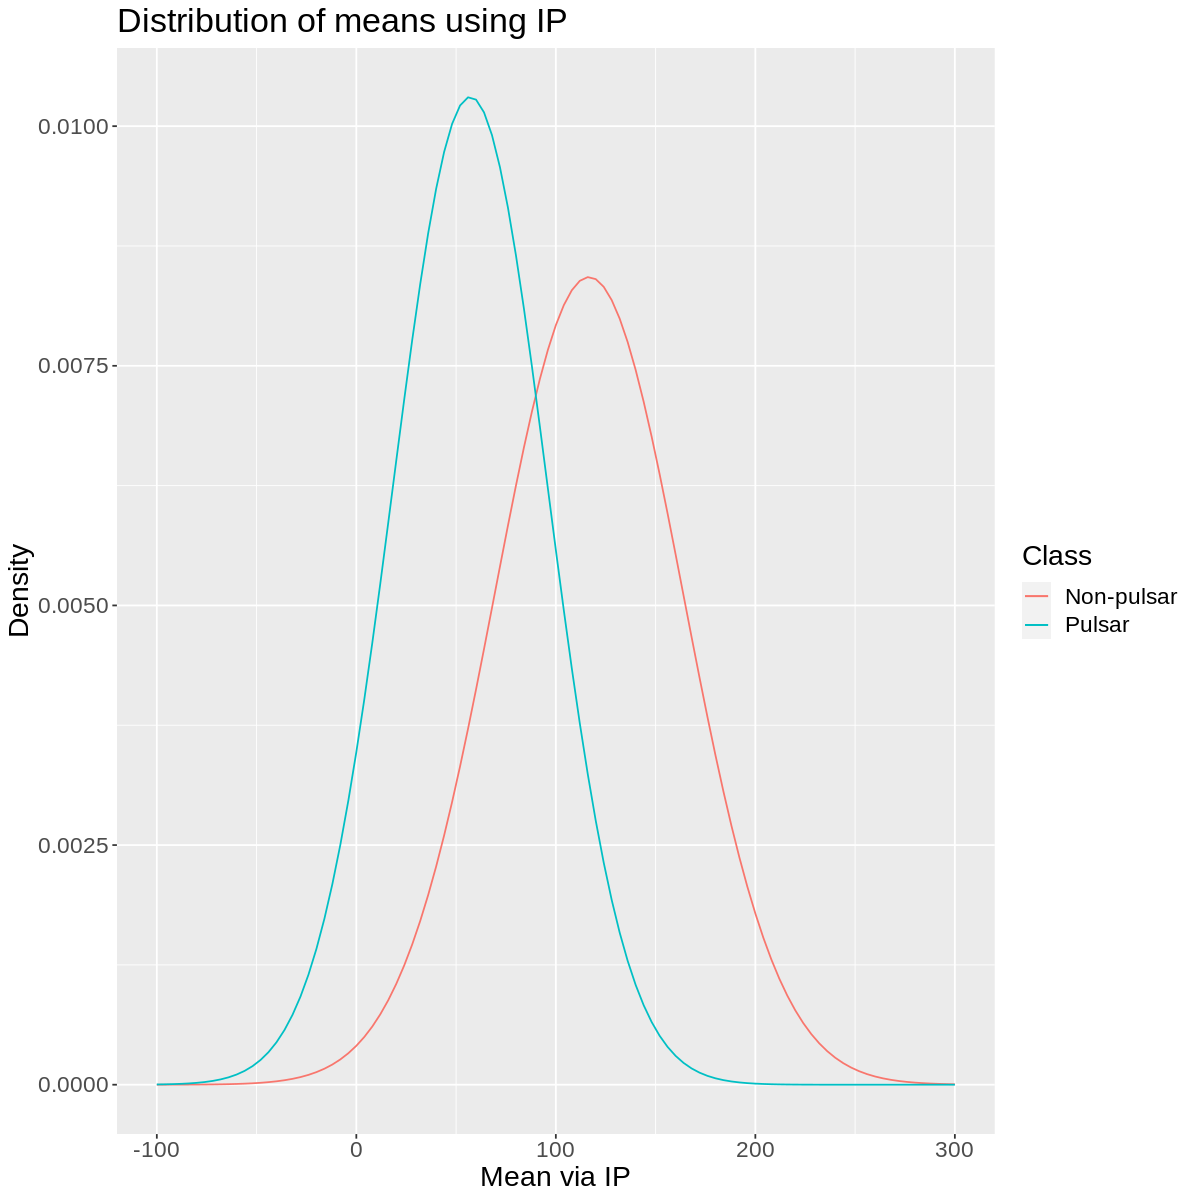

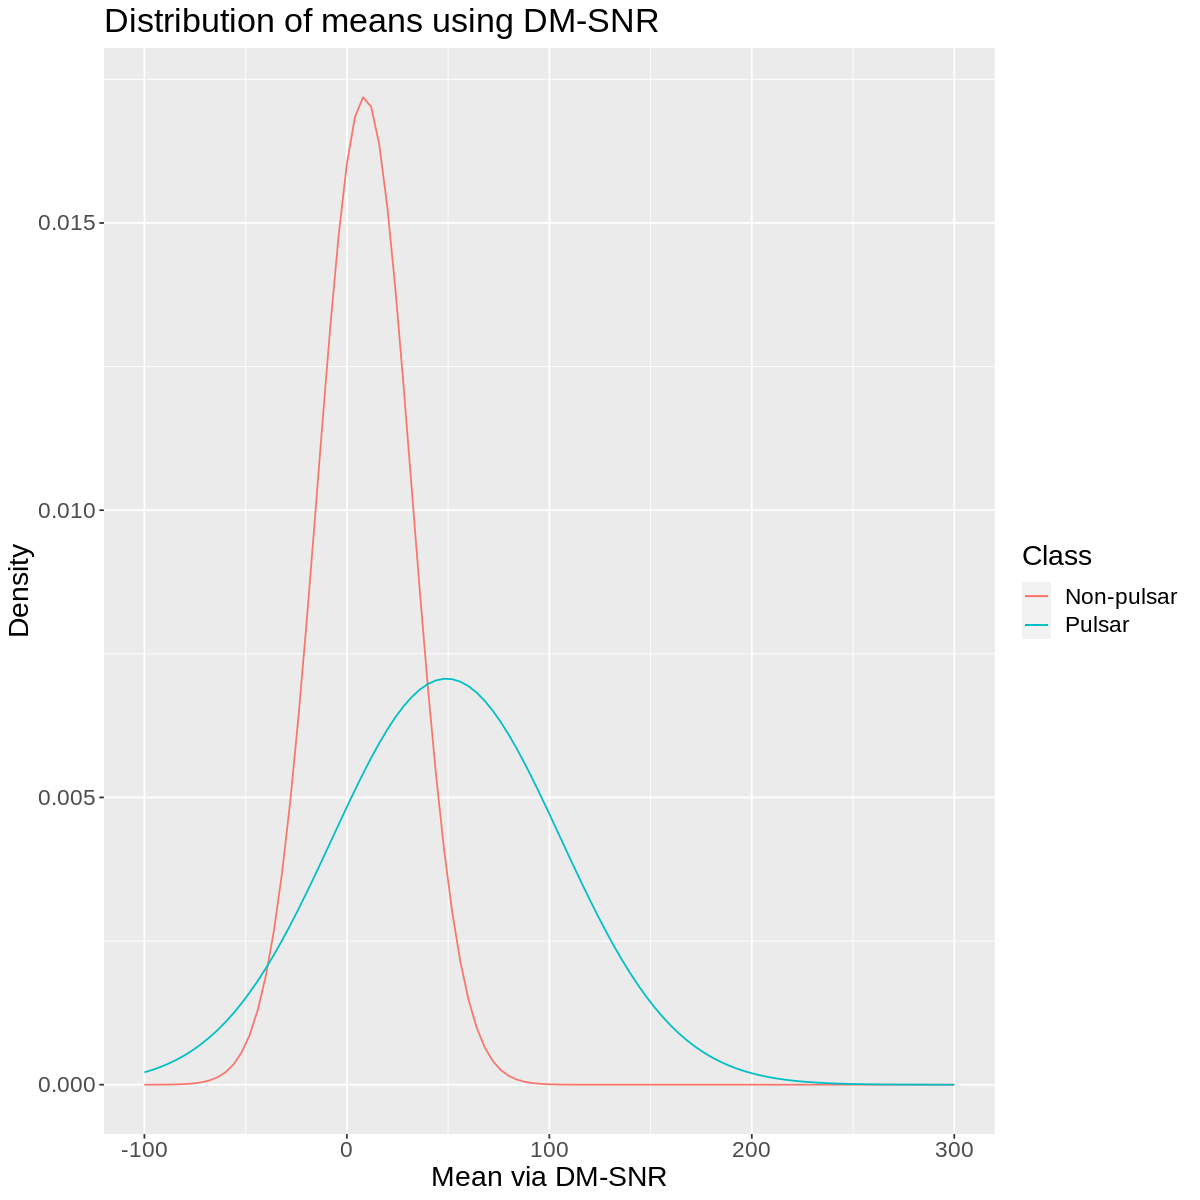

In [10]:
#We visualized the curve of the average mean of the integrated pulse profile, 
# and the DM-SNR profile for positive and negative pulsar stars.
options(repr.plot.width = 10, repr.plot.height = 10) 

IP_distribution <- ggplot() + 
  lapply(split(IP_train_summary, seq_len(nrow(IP_train_summary))), 
         \(x) stat_function(fun = dnorm, 
                            args = list(mean = x$avg_mean_ip, sd = x$avg_stdev_ip), 
                            aes(color = factor(x$Class)))) +
  theme(text = element_text(size = 17)) +
  xlim(-100,300)+
    labs(x = 'Mean via IP', y = 'Density', color = 'Class', 
         title = 'Distribution of means using IP')
IP_distribution

DM_distribution <- ggplot() + 
  lapply(split(DM_train_summary, seq_len(nrow(DM_train_summary))), 
         \(x) stat_function(fun = dnorm, 
                            args = list(mean = x$avg_mean_dm, sd = x$avg_stdev_dm), 
                            aes(color = factor(x$Class)))) +
  theme(text = element_text(size = 17)) +
  xlim(-100,300)+
    labs(x = 'Mean via DM-SNR', y = 'Density', color = 'Class', 
         title = 'Distribution of means using DM-SNR')
DM_distribution 

Figure 2: (dist of means)

## Methods

1. Creating 2 data groups:
   - Group 1: Integrated profile columns Mean_IP, Stdev_IP, Kurtosis_IP and Skewness_IP will be used to predict the Class
   - Group 2: DM-SNR profile columns Mean_DM, Stdev_DM, Kurtosis_DM and Skewness_DM will be used to predict the Class
2. Oversampling: When running knn we will use the oversampling technique since positive cases are very few compared to negative cases ((1,639 positive examples (9.16%) and 16,259 negative examples (90.85%)).
3. We will also standardize our variables.
4. Training the classification KNN models
5. Tuning the models
6. Testing the models 
7. Evaluating the models via confusion matrices and accuracy estimates
8. Picking the best classification model to predict pulsar stars based on background information.
For example, if it is more costly to investigate a false positive, we would want to choose a model with high accuracy and a low rate of false positives.



### Visualizing the results

We will visualize the results with a bar graph comparing the accuracies of each prediction model we created. 

## Conclusion: 

To make a hypothesis on which profile is better at predicting pulsar star class, we computed if the difference in means between pulsar and non-pulsar stars is significant for both profiles. Although both profiles are effective at telling a pulsar and non-pulsar star apart (p < 0.05), the integrated profile has a larger difference between the mean of pulsar and non-pulsar (larger t).

### Hypothesis: 
We hypothesize that using the integrated profile versus the DM-SNR profile will provide more accurate predictions of pulsar star class.


In [11]:
set.seed(17)

integrated_pulsar <- rnorm(1639, mean = 56.69061, sd = 38.71060)
integrated_non_pulsar <- rnorm(16259, mean= 116.56273, sd = 47.33974)

integrated_profile_t_test_result <- t.test(integrated_non_pulsar, integrated_pulsar, alternative = "two.sided", var.equal = TRUE)
integrated_profile_t_test_result

DM_pulsar <- rnorm(1639, mean = 8.863258, sd = 23.28798)
DM_non_pulsar <- rnorm(16259, mean= 49.825995, sd = 56.46896)

DM_profile_t_test_result <- t.test(DM_non_pulsar, DM_pulsar, alternative = "two.sided", var.equal = TRUE)
DM_profile_t_test_result


	Two Sample t-test

data:  integrated_non_pulsar and integrated_pulsar
t = 50.286, df = 17896, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 58.27800 63.00555
sample estimates:
mean of x mean of y 
117.39165  56.74988 



	Two Sample t-test

data:  DM_non_pulsar and DM_pulsar
t = 29.697, df = 17896, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 38.94408 44.44818
sample estimates:
mean of x mean of y 
49.614483  7.918356 


Investigating which profile best predicts the class of a pulsar star can help us to better understand and identify these cosmic phenomena. Thus, this leads us to future questions such as: if a pulsar star has been identified, what is the correlation of its findings to other cosmic phenomena such as dark matter and gravity waves? 

# knn classification

In [12]:
install.packages("themis") #needed for upsample
library (themis) #needed for upsample

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## KNN on IP

In [13]:
IP_proportions <- IP_train |>
    group_by(Class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(IP_train))

IP_proportions

Class,n,percent
<chr>,<int>,<dbl>
Non-pulsar,12201,90.896223
Pulsar,1222,9.103777


Table 7: (proportion IP)

### Undersampled

In [14]:
#Undersampling the non-pulsar stars so that proportions of each class is equal
#Also tried oversampling the pulsar stars, but undersampling offered better quality data
set.seed(17)

IP_undersample_recipe <- recipe(Class ~ ., data = IP_train) |>
    step_nearmiss(Class, under_ratio = 1) |>  
    prep()

undersampled_IP_train <- bake(IP_undersample_recipe, new_data = NULL)

#to confirm that the data is now 50/50 for each class
undersampled_IP_proportions <- undersampled_IP_train |>
    group_by(Class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(undersampled_IP_train))

undersampled_IP_proportions

Class,n,percent
<fct>,<int>,<dbl>
Non-pulsar,1222,50
Pulsar,1222,50


Table 8: (proportion undersampled IP)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,accuracy,binary,0.9267598,5,0.005415143,Preprocessor1_Model05
26,accuracy,binary,0.9259435,5,0.005295173,Preprocessor1_Model06
16,accuracy,binary,0.9259418,5,0.006814524,Preprocessor1_Model04
⋮,⋮,⋮,⋮,⋮,⋮,⋮
76,accuracy,binary,0.9161258,5,0.006148886,Preprocessor1_Model16
81,accuracy,binary,0.9148980,5,0.006595868,Preprocessor1_Model17
1,accuracy,binary,0.8858414,5,0.002382325,Preprocessor1_Model01


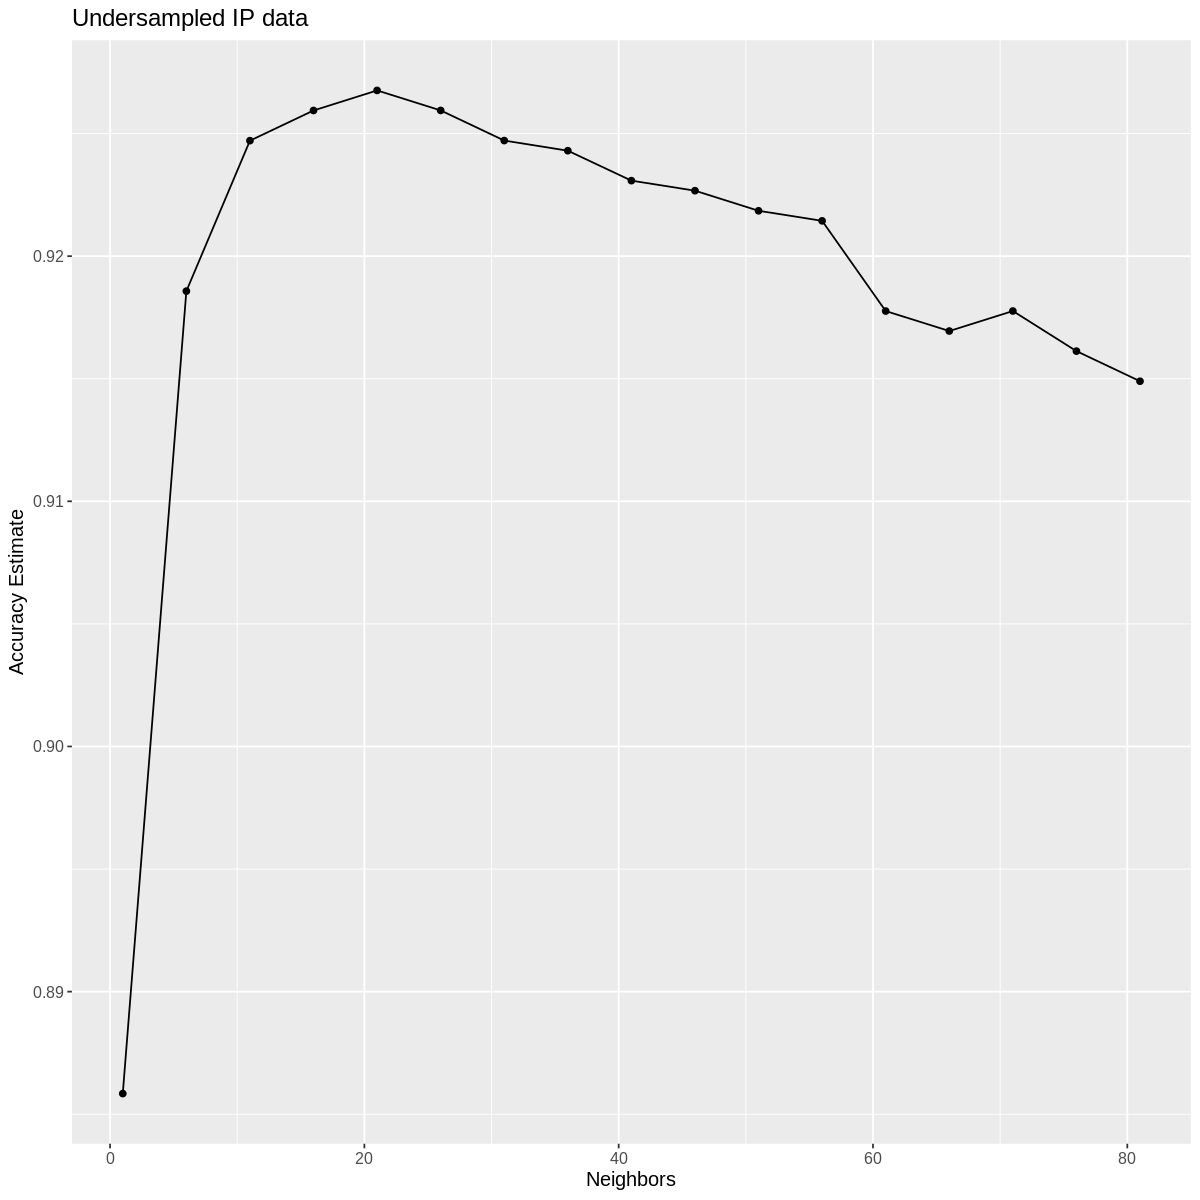

In [15]:
#knn on undersampled IP training data with 5-fold cross-validation to pick K
#starting with a wide range of K values and will narrow down after to reduce run-time 

set.seed(17)

unders_IP_recipe <- recipe(Class ~ ., data = undersampled_IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

IP_spec_train <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

unders_IP_vfold <- vfold_cv(undersampled_IP_train, v = 5, strata = Class)

k_vals <- tibble(neighbors = seq(from = 1, to = 81, by = 5)) 

unders_knn_fit <- workflow() |>
    add_recipe(unders_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
unders_knn_fit

accuracy_vs_k <- ggplot(unders_knn_fit, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Undersampled IP data", x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12))
accuracy_vs_k

Table 10: (IP fit)

Figure 3: 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,accuracy,binary,0.9267598,5,0.005415143,Preprocessor1_Model06
22,accuracy,binary,0.9267598,5,0.005415143,Preprocessor1_Model07
17,accuracy,binary,0.9263483,5,0.006621810,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
16,accuracy,binary,0.9259418,5,0.006814524,Preprocessor1_Model01
19,accuracy,binary,0.9259418,5,0.006368591,Preprocessor1_Model04
20,accuracy,binary,0.9259418,5,0.006368591,Preprocessor1_Model05


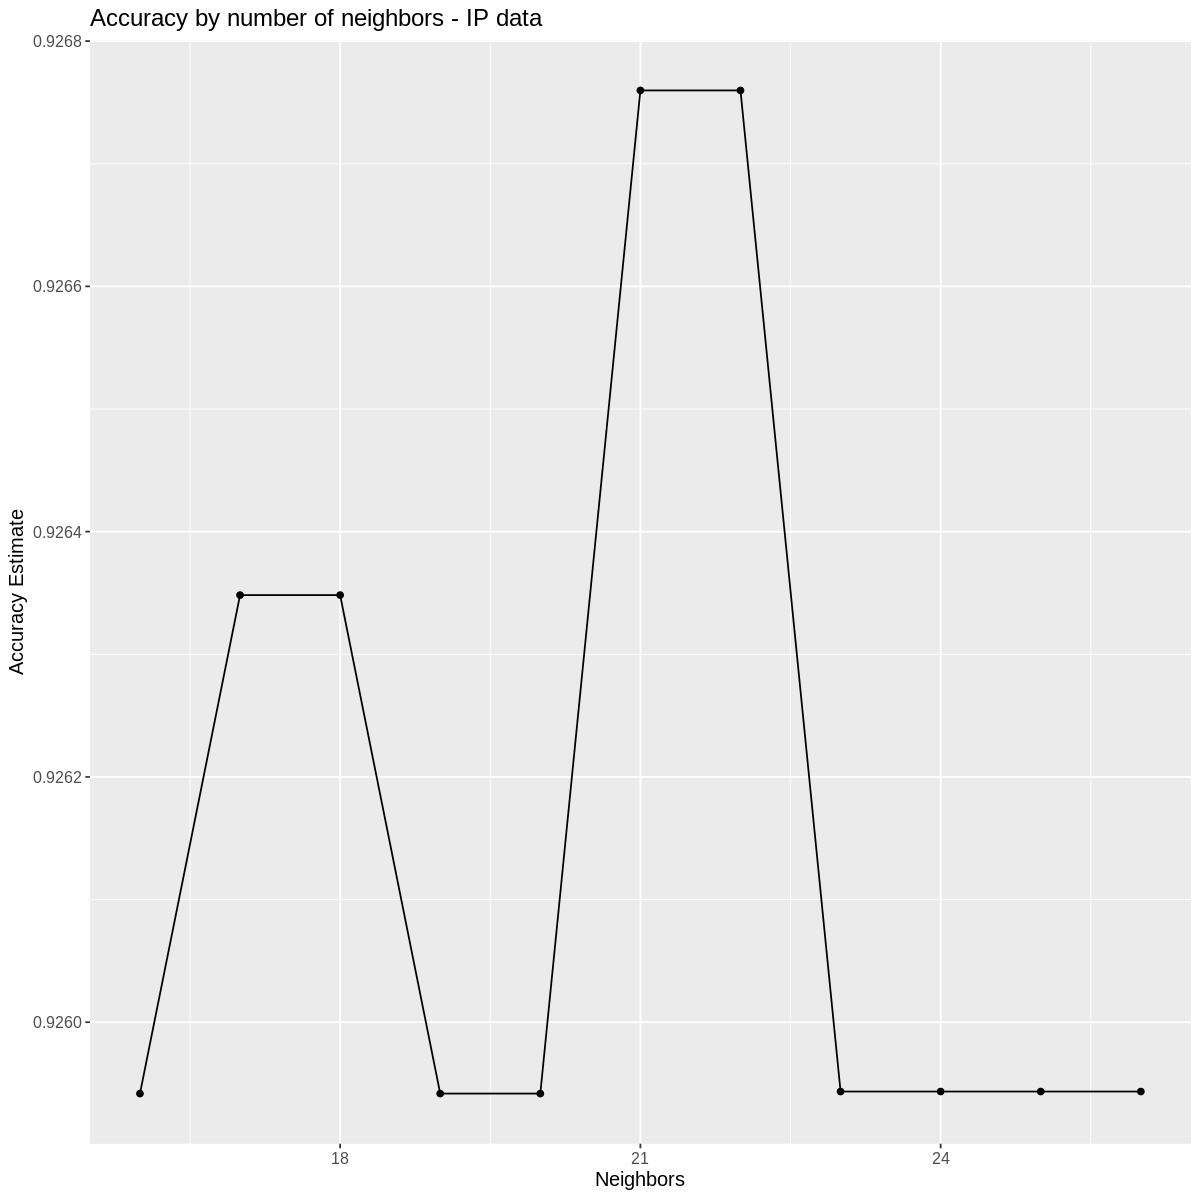

In [16]:
#Check smaller range of K-values around the peak to find single best
set.seed(17)

precise_k_vals_IP <- tibble(neighbors = seq(from = 16, to = 26, by = 1)) 

precise_knn_fit_IP <- workflow() |>
    add_recipe(unders_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = precise_k_vals_IP) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
precise_knn_fit_IP

accuracy_vs_k <- ggplot(precise_knn_fit_IP, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Accuracy by number of neighbors - IP data", x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_k

Table 11: (precise IP fit)

Figure 4: 

### Best K = 21 (mean = 0.923)

In [17]:
#Using best K to make the IP model
#Chose 21 over 22 because it's closer to the other peak at 17-18
set.seed(17)

IP_spec_test <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
    set_engine("kknn") |>
    set_mode("classification")

IP_fit_test <- workflow() |> 
    add_recipe(unders_IP_recipe) |> 
    add_model(IP_spec_test) |>
    fit(data = undersampled_IP_train)

#needed to fix an error where factor levels were in the wrong order, so wouldn't calculate metrics
IP_test <- IP_test |> 
    mutate(Class = as_factor(Class))
IP_test$Class <- factor(IP_test$Class, levels=c('Non-pulsar', 'Pulsar'))

#Checking the model against the test data
IP_test_predictions <- predict(IP_fit_test, IP_test) |>  
    bind_cols(IP_test) 

IP_accuracy <- IP_test_predictions |>
    metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
IP_accuracy

IP_conf_mat <- IP_test_predictions |> 
    conf_mat(truth = Class, estimate = .pred_class)
IP_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9671508


            Truth
Prediction   Non-pulsar Pulsar
  Non-pulsar       3956     45
  Pulsar            102    372

Table 12: (IP conf mat)

The model above is ~97% accurate (very good), but misses ~12% of pulsars (less good). I think we'd rather over-estimate pulsar's than miss some. This model could be used to filter the data, and the hits could be manually checked afterwards for confirmation. So better to not miss Pulsars I think.   

## KNN on DM-SNR

In [18]:
#Undersampling the non-pulsar stars so that proportions of each class is equal
#Also tried oversampling the pulsar stars, but undersampling offered better quality data
set.seed(17)

DMSNR_undersample_recipe <- recipe(Class ~ ., data = DM_train) |>
    step_nearmiss(Class, under_ratio = 1) |>  #undersampling
    prep()

undersampled_DMSNR_train <- bake(DMSNR_undersample_recipe, new_data = NULL)

undersampled_DMSNR_proportions <- undersampled_DMSNR_train |>
    group_by(Class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(undersampled_DMSNR_train))

undersampled_DMSNR_proportions

Class,n,percent
<fct>,<int>,<dbl>
Non-pulsar,1211,50
Pulsar,1211,50


Table 13: (unders DMSNR prop)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
36,accuracy,binary,0.8711645,5,0.008635010,Preprocessor1_Model08
51,accuracy,binary,0.8707479,5,0.009714088,Preprocessor1_Model11
46,accuracy,binary,0.8699231,5,0.009408707,Preprocessor1_Model10
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.8616723,5,0.006120474,Preprocessor1_Model03
6,accuracy,binary,0.8542496,5,0.004936528,Preprocessor1_Model02
1,accuracy,binary,0.8162653,5,0.002803727,Preprocessor1_Model01


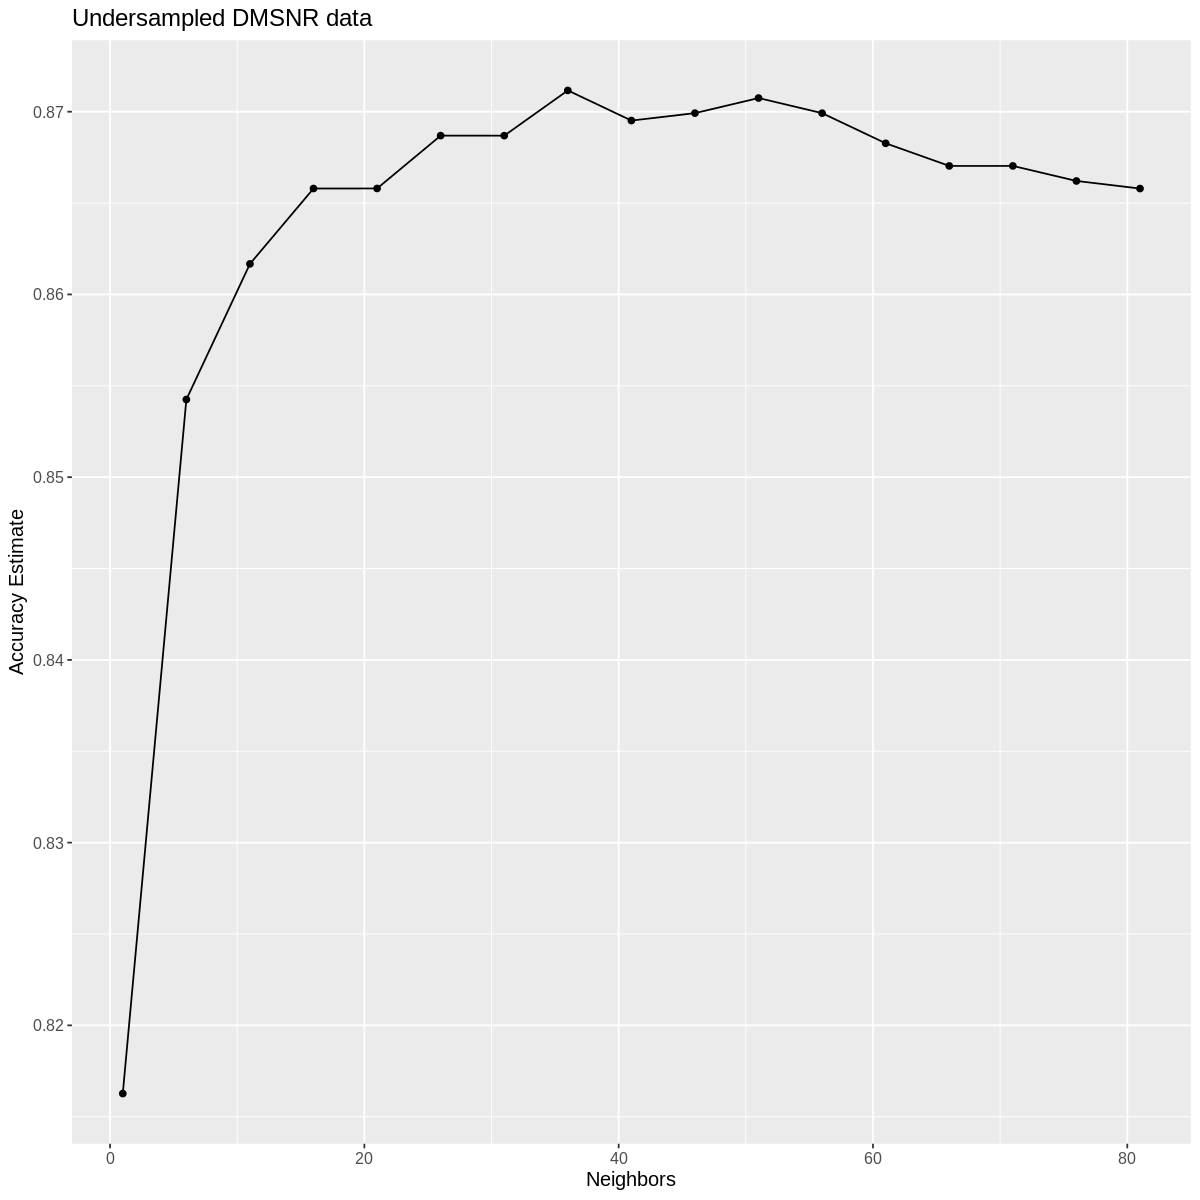

In [19]:
#knn on undersampled DMSNR training data with 5-fold cross-validation to pick K
#starting with a wide range of K values and will narrow down after to reduce run-time 
set.seed(17)

unders_DMSNR_recipe <- recipe(Class ~ ., data = undersampled_DMSNR_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

DMSNR_spec_train <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

unders_DMSNR_vfold <- vfold_cv(undersampled_DMSNR_train, v = 5, strata = Class)

k_vals <- tibble(neighbors = seq(from = 1, to = 81, by = 5)) 

unders_knn_fit <- workflow() |>
    add_recipe(unders_DMSNR_recipe) |>
    add_model(DMSNR_spec_train) |>
    tune_grid(resamples = unders_DMSNR_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
unders_knn_fit

accuracy_vs_k <- ggplot(unders_knn_fit, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Undersampled DMSNR data", x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12))
accuracy_vs_k

Table 14: (dmsnr fit)

Figure 5:

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
35,accuracy,binary,0.8711645,5,0.008635010,Preprocessor1_Model05
36,accuracy,binary,0.8711645,5,0.008635010,Preprocessor1_Model06
33,accuracy,binary,0.8703415,5,0.007818164,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
38,accuracy,binary,0.8691001,5,0.009046394,Preprocessor1_Model08
31,accuracy,binary,0.8686886,5,0.006552128,Preprocessor1_Model01
32,accuracy,binary,0.8686886,5,0.006552128,Preprocessor1_Model02


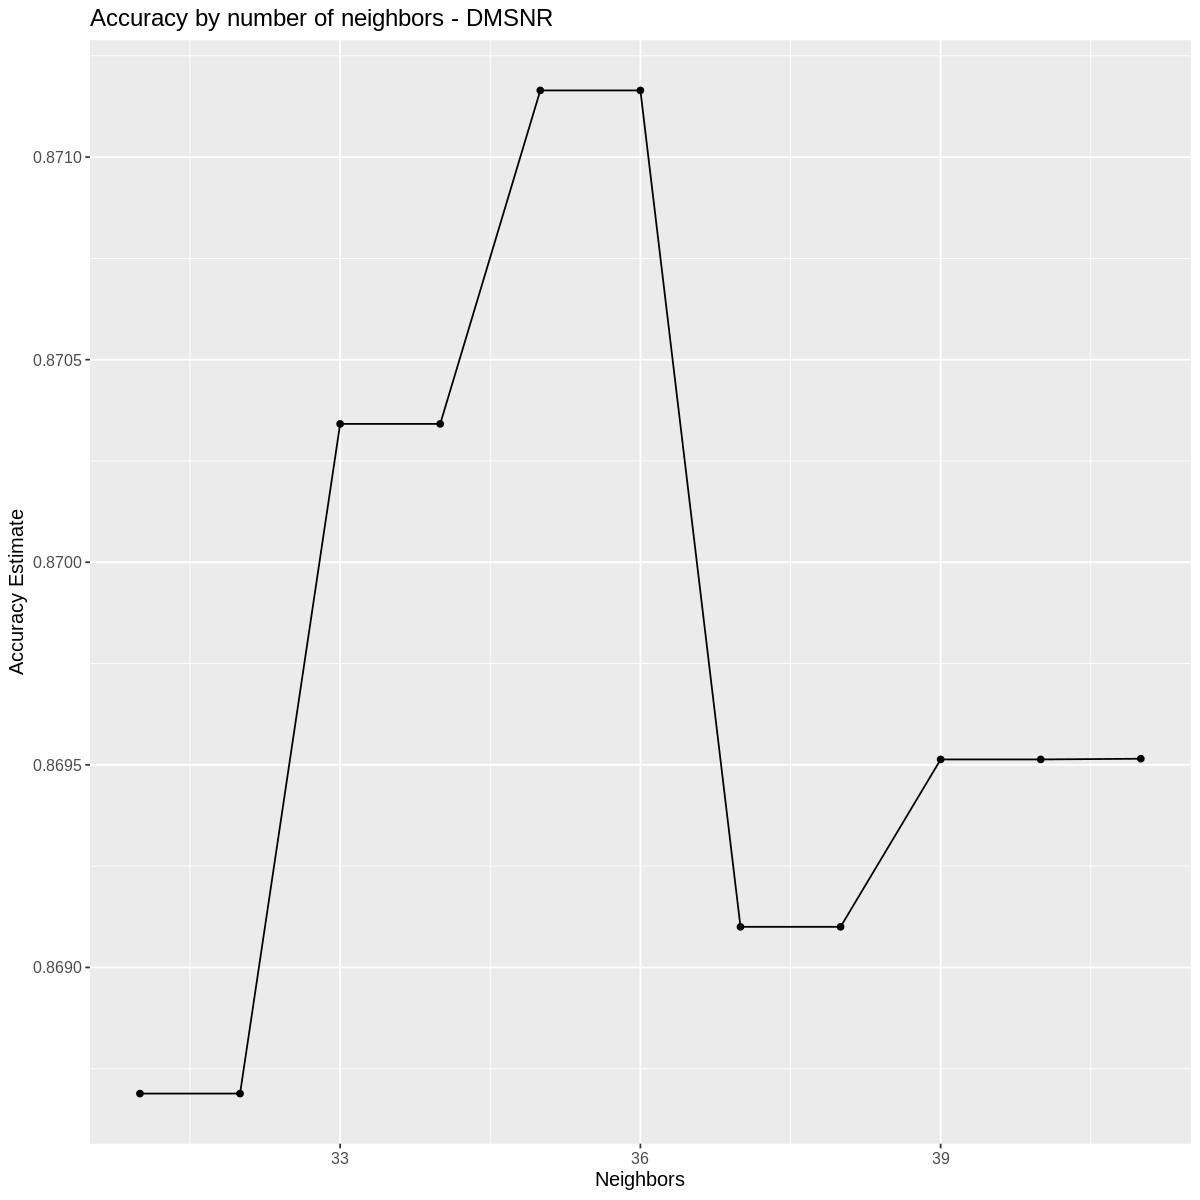

In [20]:
#Check smaller range of K-values around the peak to find single best
set.seed(17)

precise_k_vals_2 <- tibble(neighbors = seq(from = 31, to = 41, by = 1)) 

precise_knn_fit <- workflow() |>
    add_recipe(unders_DMSNR_recipe) |>
    add_model(DMSNR_spec_train) |>
    tune_grid(resamples = unders_DMSNR_vfold, grid = precise_k_vals_2) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
precise_knn_fit

accuracy_vs_k_2 <- ggplot(precise_knn_fit, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Accuracy by number of neighbors - DMSNR", x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_k_2

Table 15: (precise dmsnr fit)

Figure 6:

### Best K = 35 (mean = ~0.871)

In [21]:
#Using found K to make model
#Chose 35 over 36 since neighboring values are higher

DMSNR_spec_test <- nearest_neighbor(weight_func = "rectangular", neighbors = 35) |>
    set_engine("kknn") |>
    set_mode("classification")

DMSNR_fit_test <- workflow() |> 
    add_recipe(unders_DMSNR_recipe) |> 
    add_model(DMSNR_spec_test) |>
    fit(data = undersampled_DMSNR_train)

#needed to fix an error where factor levels were in the wrong order, so wouldn't calculate metrics
DM_test <- DM_test |> 
    mutate(Class = as_factor(Class))
DM_test$Class <- factor(DM_test$Class, levels=c('Non-pulsar', 'Pulsar'))

DMSNR_test_predictions <- predict(DMSNR_fit_test, DM_test) |>  
    bind_cols(DM_test) 

#Checking the model against the test data
DMSNR_accuracy <- DMSNR_test_predictions |>
    metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
DMSNR_accuracy

DMSNR_conf_mat <- DMSNR_test_predictions |> 
    conf_mat(truth = Class, estimate = .pred_class)
DMSNR_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8386592


            Truth
Prediction   Non-pulsar Pulsar
  Non-pulsar       3377     52
  Pulsar            670    376

Table 16: (dmsnr conf mat)

The model above is ~84% accurate (less good), and misses ~14% of pulsars (also less good).

## KNN on the combined data - using all predictors from both methods

In [22]:
#Undersampling the non-pulsar stars so that proportions of each class is equal
#Also tried oversampling the pulsar stars, but undersampling offered better quality data
set.seed(17)

both_undersample_recipe <- recipe(Class ~ ., data = both_train) |>
    step_nearmiss(Class, under_ratio = 1) |> 
    prep()

undersampled_both_train <- bake(both_undersample_recipe, new_data = NULL)

undersampled_both_proportions <- undersampled_both_train |>
    group_by(Class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(undersampled_both_train))

undersampled_both_proportions

Class,n,percent
<fct>,<int>,<dbl>
Non-pulsar,1239,50
Pulsar,1239,50


Table 17: (combined proportions)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.9366495,5,0.005985011,Preprocessor1_Model03
16,accuracy,binary,0.9326188,5,0.006772078,Preprocessor1_Model04
6,accuracy,binary,0.9322140,5,0.005055755,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
71,accuracy,binary,0.9160686,5,0.006244141,Preprocessor1_Model15
76,accuracy,binary,0.9156638,5,0.005731797,Preprocessor1_Model16
81,accuracy,binary,0.9136444,5,0.005482872,Preprocessor1_Model17


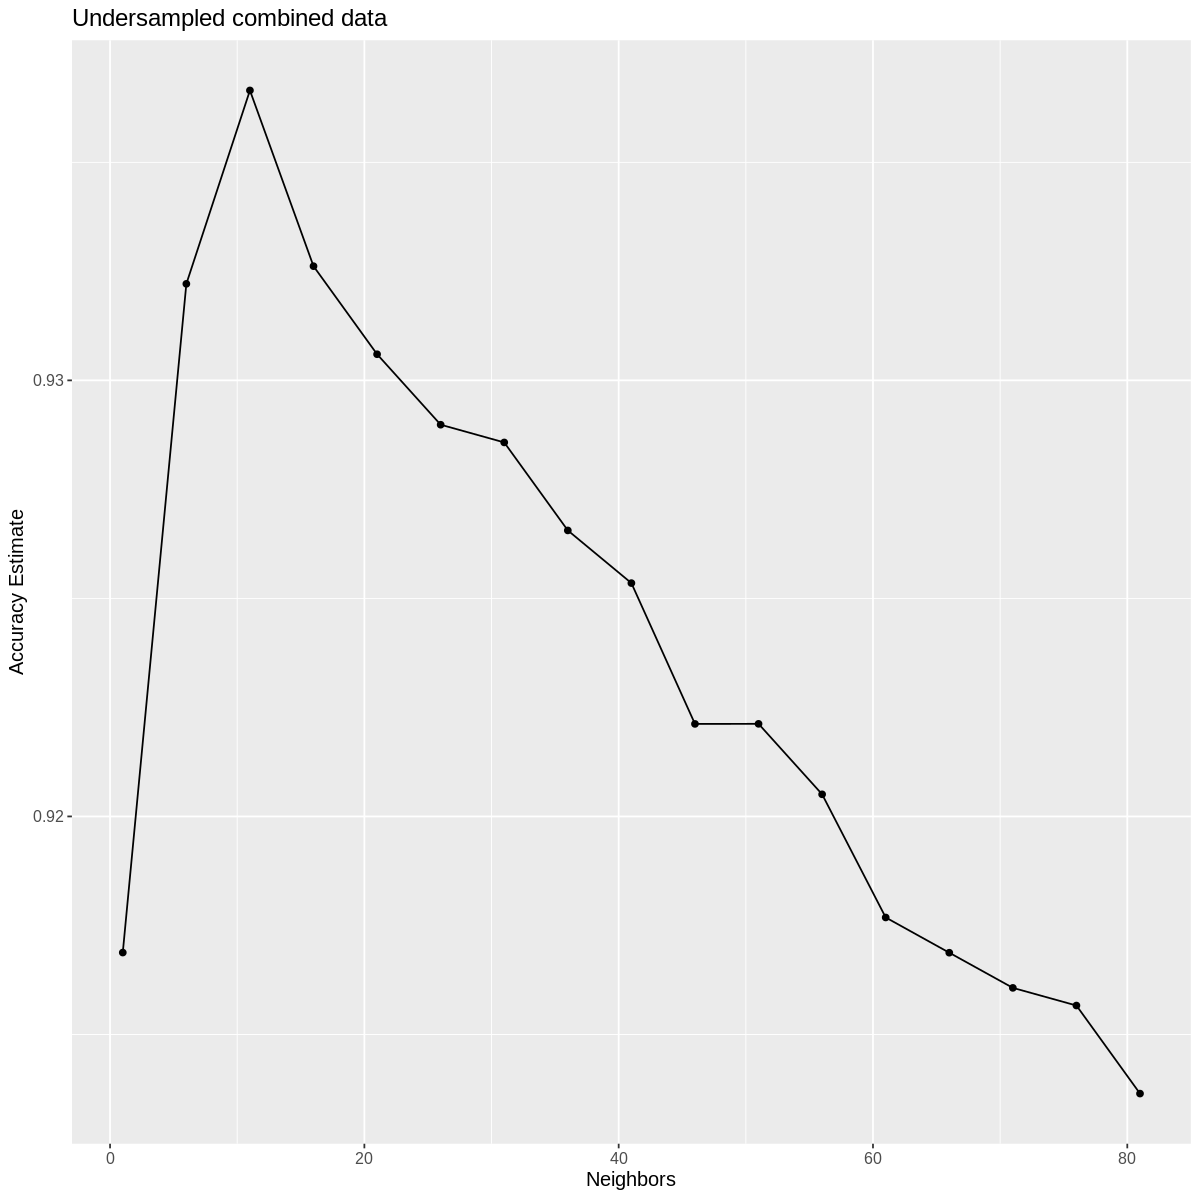

In [23]:
#knn on undersampled combined training data with 5-fold cross-validation to pick K
#starting with a wide range of K values and will narrow down after to reduce run-time 
set.seed(17)

unders_both_recipe <- recipe(Class ~ ., data = undersampled_both_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

both_spec_train <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

unders_both_vfold <- vfold_cv(undersampled_both_train, v = 5, strata = Class)

k_vals <- tibble(neighbors = seq(from = 1, to = 81, by = 5)) 

unders_knn_fit <- workflow() |>
    add_recipe(unders_both_recipe) |>
    add_model(both_spec_train) |>
    tune_grid(resamples = unders_both_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
unders_knn_fit

accuracy_vs_k <- ggplot(unders_knn_fit, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Undersampled combined data", x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12))
accuracy_vs_k

Table 18: (combined knn fit)

Figure 7: 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.9366495,5,0.005985011,Preprocessor1_Model06
12,accuracy,binary,0.9366495,5,0.005985011,Preprocessor1_Model07
9,accuracy,binary,0.9358414,5,0.005877089,Preprocessor1_Model04
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,accuracy,binary,0.9326156,5,0.006181104,Preprocessor1_Model08
14,accuracy,binary,0.9326156,5,0.006181104,Preprocessor1_Model09
6,accuracy,binary,0.9322140,5,0.005055755,Preprocessor1_Model01


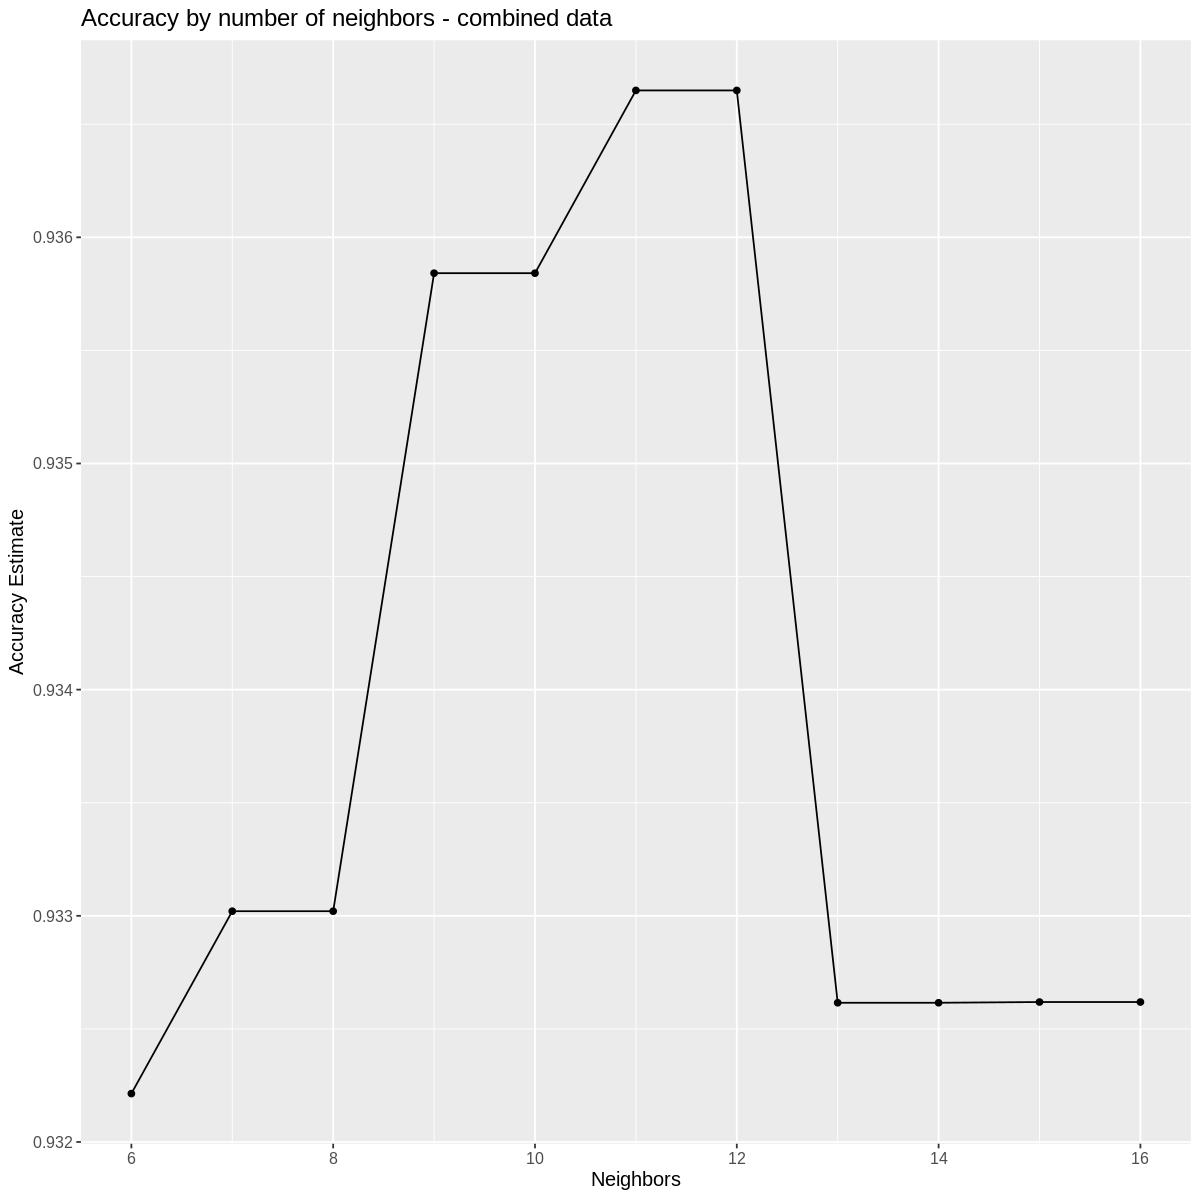

In [24]:
#Check smaller range of K-values around the peak to find single best
set.seed(17)

precise_k_vals_2 <- tibble(neighbors = seq(from = 6, to = 16, by = 1)) 

precise_knn_fit <- workflow() |>
    add_recipe(unders_both_recipe) |>
    add_model(both_spec_train) |>
    tune_grid(resamples = unders_both_vfold, grid = precise_k_vals_2) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
precise_knn_fit

accuracy_vs_k_2 <- ggplot(precise_knn_fit, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Accuracy by number of neighbors - combined data", x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_k_2

Table 19: (combined knn fit)

Figure 8: 

### Best K = 11 (mean = ~0.937)

In [25]:
#Using found K to make model

both_spec_test <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
    set_engine("kknn") |>
    set_mode("classification")

both_fit_test <- workflow() |> 
    add_recipe(unders_both_recipe) |> 
    add_model(both_spec_test) |>
    fit(data = undersampled_both_train)

#needed to fix an error where factor levels were in the wrong order, so wouldn't calculate metrics
both_test <- both_test |> 
    mutate(Class = as_factor(Class))
both_test$Class <- factor(both_test$Class, levels=c('Non-pulsar', 'Pulsar'))

both_test_predictions <- predict(both_fit_test, both_test) |>  
    bind_cols(both_test) 

#Checking the model against the test data
both_accuracy <- both_test_predictions |>
    metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
both_accuracy

both_conf_mat <- both_test_predictions |> 
    conf_mat(truth = Class, estimate = .pred_class)
both_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9126257


            Truth
Prediction   Non-pulsar Pulsar
  Non-pulsar       3723     39
  Pulsar            352    361

Table 20: (combined conf mat)

Overall accuracy of ~91% (slightly lower) but only misses less than 11% of pulsar stars (best). 

# Below this is extra stuff; not needed

### Original Data (looks like we're using undersampled data but keeping a copy of this in case we want it later)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,accuracy,binary,0.9781719,5,0.0010438339,Preprocessor1_Model03
31,accuracy,binary,0.9780228,5,0.0009712746,Preprocessor1_Model04
11,accuracy,binary,0.9774269,5,0.0011982940,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
91,accuracy,binary,0.9765327,5,0.001252949,Preprocessor1_Model10
101,accuracy,binary,0.9761602,5,0.001060737,Preprocessor1_Model11
1,accuracy,binary,0.9644647,5,0.002461749,Preprocessor1_Model01


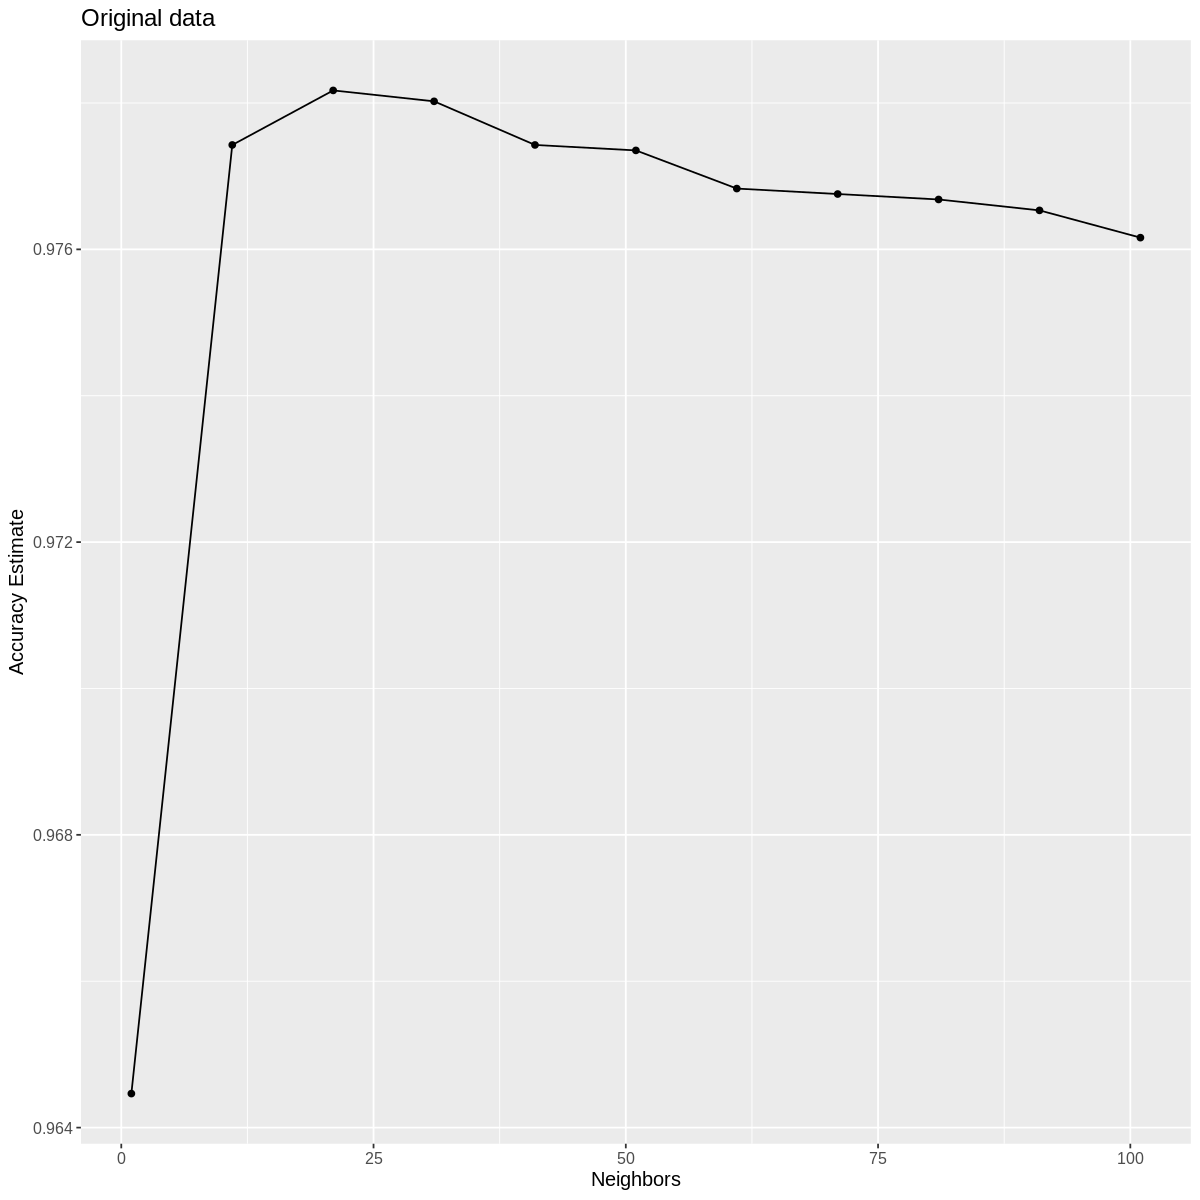

In [26]:
#knn with cross-validation to pick K
#starting with a wide range of K values and will narrow down after to reduce run-time 
#still takes a long time to run (over 3-mins)
set.seed(17)

IP_recipe <- recipe(Class ~ ., data = IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

IP_spec_train <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

IP_vfold <- vfold_cv(IP_train, v = 5, strata = Class)

k_vals <- tibble(neighbors = seq(from = 1, to = 101, by = 10)) 

knn_fit <- workflow() |>
  add_recipe(IP_recipe) |>
  add_model(IP_spec_train) |>
  tune_grid(resamples = IP_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean))
knn_fit

accuracy_vs_k <- ggplot(knn_fit, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Original data", x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_k

### Oversampled Data (looks like we're using undersampled data but keeping a copy of this in case we want it later)

In [27]:
#Upsampling the data

IP_upsample_recipe <- recipe(Class ~ ., data = IP_train) |>
    step_upsample(Class, over_ratio = 1, skip = FALSE) |>  #oversampling
#    step_nearmiss(Class, under_ratio = 1, skip = FALSE) |>  #undersampling
    prep()

upsampled_IP_train <- bake(IP_upsample_recipe, new_data = NULL)

upsampled_IP_proportions <- upsampled_IP_train |>
    group_by(Class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(upsampled_IP_train))

upsampled_IP_proportions

Class,n,percent
<fct>,<int>,<dbl>
Non-pulsar,12201,50
Pulsar,12201,50


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9888125,5,0.0005081549,Preprocessor1_Model01
11,accuracy,binary,0.9512741,5,0.0014395249,Preprocessor1_Model02
21,accuracy,binary,0.9393900,5,0.0013406082,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
81,accuracy,binary,0.9312760,5,0.001343523,Preprocessor1_Model09
101,accuracy,binary,0.9310710,5,0.001481242,Preprocessor1_Model11
91,accuracy,binary,0.9300055,5,0.001178168,Preprocessor1_Model10


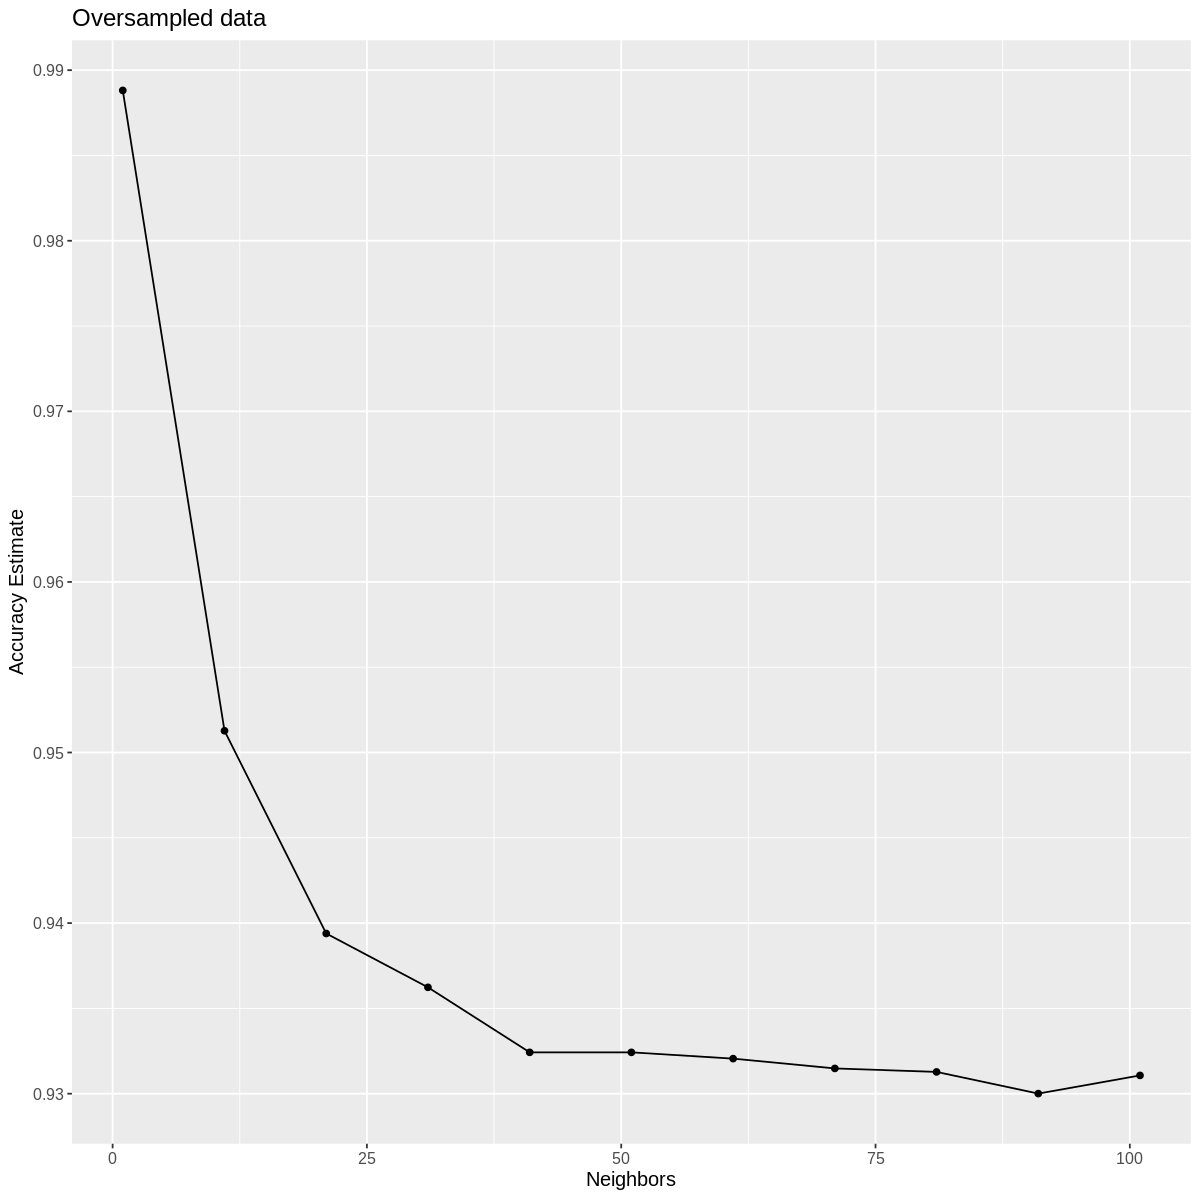

In [28]:
#knn with cross-validation to pick K
#starting with a wide range of K values and will narrow down after to reduce run-time 
#still takes a long time to run (over 3-mins)
set.seed(17)

ups_IP_recipe <- recipe(Class ~ ., data = upsampled_IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

IP_spec_train <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

ups_IP_vfold <- vfold_cv(upsampled_IP_train, v = 5, strata = Class)

k_vals <- tibble(neighbors = seq(from = 1, to = 101, by = 10)) 

ups_knn_fit <- workflow() |>
  add_recipe(ups_IP_recipe) |>
  add_model(IP_spec_train) |>
  tune_grid(resamples = ups_IP_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean))
ups_knn_fit

accuracy_vs_k <- ggplot(ups_knn_fit, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Oversampled data", x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_k

## Trying models with different combinations of variables (only mean, mean + SD, etc). 

In [ ]:
set.seed(17)

IP_spec_train <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

unders_IP_vfold <- vfold_cv(undersampled_IP_train, v = 5, strata = Class)

k_vals <- tibble(neighbors = seq(from = 1, to = 51, by = 5)) 

#Mean only
mean_only_IP_recipe <- recipe(Class ~ Mean_IP, data = undersampled_IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

mean_only <- workflow() |>
    add_recipe(mean_only_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "Mean", x = "Neighbors", y = "Accuracy Estimate") + 
        theme(text = element_text(size = 12))

#Stdev only
stdev_only_IP_recipe <- recipe(Class ~ Stdev_IP, data = undersampled_IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

stdev_only <- workflow() |>
    add_recipe(stdev_only_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "Stdev", x = "Neighbors", y = "Accuracy Estimate") + 
        theme(text = element_text(size = 12))

#Kurtosis only
kurtosis_only_IP_recipe <- recipe(Class ~ Kurtosis_IP, data = undersampled_IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

kurt_only <- workflow() |>
    add_recipe(kurtosis_only_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "Kurtosis", x = "Neighbors", y = "Accuracy Estimate") + 
        theme(text = element_text(size = 12))

#Skewness only
skewness_only_IP_recipe <- recipe(Class ~ Skewness_IP, data = undersampled_IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

skewness_only <- workflow() |>
    add_recipe(skewness_only_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "Skewness", x = "Neighbors", y = "Accuracy Estimate") + 
        theme(text = element_text(size = 12))

Comparing_recipes <- plot_grid(mean_only, stdev_only, kurt_only, skewness_only, ncol = 2)
Comparing_recipes

In [ ]:
set.seed(17)

#Kurtosis + Mean
kurt_mean_IP_recipe <- recipe(Class ~ Kurtosis_IP + Mean_IP, data = undersampled_IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

kurt_mean <- workflow() |>
    add_recipe(kurt_mean_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "Kurtosis + Mean", x = "Neighbors", y = "Accuracy Estimate") + 
        theme(text = element_text(size = 12))

#Kurtosis + Stdev
kurt_stdev_IP_recipe <- recipe(Class ~ Kurtosis_IP + Stdev_IP, data = undersampled_IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

kurt_stdev <- workflow() |>
    add_recipe(kurt_stdev_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "Kurtosis + Stdev", x = "Neighbors", y = "Accuracy Estimate") + 
        theme(text = element_text(size = 12))

#Kurtosis + Skewness
kurt_skew_IP_recipe <- recipe(Class ~ Kurtosis_IP + Skewness_IP, data = undersampled_IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

kurt_skew <- workflow() |>
    add_recipe(kurt_skew_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "Kurtosis + Skewness", x = "Neighbors", y = "Accuracy Estimate") + 
        theme(text = element_text(size = 12))

Comparing_recipes_2 <- plot_grid(kurt_mean, kurt_stdev, kurt_skew, ncol = 2)
Comparing_recipes_2

In [ ]:
set.seed(17)

#Kurtosis + Stdev + Mean
kurt_sd_mean_IP_recipe <- recipe(Class ~ Kurtosis_IP + Stdev_IP + Mean_IP, data = undersampled_IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

kurt_sd_mean <- workflow() |>
    add_recipe(kurt_sd_mean_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "Kurtosis + Stdev + Mean", x = "Neighbors", y = "Accuracy Estimate") + 
        theme(text = element_text(size = 12))

#Kurtosis + Stdev + Skewness
kurt_stdev_skew_IP_recipe <- recipe(Class ~ Kurtosis_IP + Stdev_IP + Skewness_IP, data = undersampled_IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

kurt_stdev_skew <- workflow() |>
    add_recipe(kurt_stdev_skew_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "Kurtosis + Stdev + Skewness", x = "Neighbors", y = "Accuracy Estimate") + 
        theme(text = element_text(size = 12))


Comparing_recipes_3 <- plot_grid(kurt_sd_mean, kurt_stdev_skew)
Comparing_recipes_3

In [ ]:
set.seed(17)

#Kurtosis + Stdev + Skewness + Mean
all_vars_IP_recipe <- recipe(Class ~ Kurtosis_IP + Stdev_IP + Mean_IP + Skewness_IP, data = undersampled_IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

all_vars_mean <- workflow() |>
    add_recipe(all_vars_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "All variables", x = "Neighbors", y = "Accuracy Estimate") + 
        theme(text = element_text(size = 12))
all_vars_mean

In [ ]:
#Can use this to narrow down k-val from by checking smaller range by 1
#also takes a long time to run (over 4-min)
set.seed(17)

precise_k_vals_2 <- tibble(neighbors = seq(from = 16, to = 26, by = 1)) 

precise_knn_fit <- workflow() |>
    add_recipe(unders_mean_only_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = precise_k_vals_2) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
precise_knn_fit

accuracy_vs_k <- ggplot(precise_knn_fit, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Accuracy by number of neighbors", x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_k

In [ ]:
#Using found K to make model

IP_spec_test <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
    set_engine("kknn") |>
    set_mode("classification")

IP_fit_test <- workflow() |> 
    add_recipe(unders_IP_recipe) |> 
    add_model(IP_spec_test) |>
    fit(data = undersampled_IP_train)

#needed to fix an error where factor levels were in the wrong order, so wouldn't calculate metrics
IP_test <- IP_test |> 
    mutate(Class = as_factor(Class))
IP_test$Class <- factor(IP_test$Class, levels=c('Non-pulsar', 'Pulsar'))

IP_test_predictions <- predict(IP_fit_test, IP_test) |>  
    bind_cols(IP_test) 

IP_accuracy <- IP_test_predictions |>
    metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
IP_accuracy

IP_conf_mat <- IP_test_predictions |> 
    conf_mat(truth = Class, estimate = .pred_class)
IP_conf_mat